In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import pandas as pd

# Read the .txt file into a DataFrame
# If the delimiter is not a comma, adjust the 'delimiter' parameter accordingly
df = pd.read_csv('Data/Idaho/file.txt', delimiter='\t')  # Use '\t' for tab-delimited files

# Save the DataFrame as a .csv file
df.to_csv('file.csv', index=False)  # 'index=False' avoids writing row indices to the file


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Idaho/file.txt'

In [ ]:
df = pd.read_csv('Data/BC/collective1972-2023.csv')
# df = pd.read_csv('Data/BC/liard1944-2013.csv')

df = df[~df['CITY'].isin(['Jasper', 'Prince George'])]

# Extract year, month, and day into separate columns
df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
# df['Month'] = df['LOCAL_DATE'].dt.month
# df = pd.get_dummies(df, columns=['Month'])


# Drop any non-numeric columns that aren't needed for training
df.drop(['LOCAL_DATE', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST',  
          'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_RAIN', 'TOTAL_SNOW', 'SNOW_ON_GROUND', 'Flow-2', 'Flow-3', 'HEATING_DEGREE_DAYS'], axis=1, inplace=True)

# # Create new columns with flow values after 1 day, 2 days, 3 days
df['Flow+1'] = df['Flow0'].shift(-1)  # Shift up by 1
df['Flow+2'] = df['Flow0'].shift(-2)  # Shift up by 2
df['Flow+3'] = df['Flow0'].shift(-3)  # Shift up by 3


# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# Linear interpolation (default)
df_imputed = df.interpolate(method='linear')
df_imputed = df.dropna()

print(df_imputed.describe())
# Define X and Y
Y = df_imputed[['Flow+3']]  # Target variable
# Y = df_imputed[['Flow+3']]  # Target variable
X = df_imputed.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X = df_imputed.drop(['Flow0'], axis=1)  # Features


       MAX_REL_HUMIDITY  MIN_REL_HUMIDITY  TOTAL_PRECIPITATION  \
count       5362.000000       5362.000000          5362.000000   
mean          89.305483         51.635024             1.637430   
std           10.080534         19.854839             3.548594   
min           43.000000         11.000000             0.000000   
25%           85.000000         35.000000             0.000000   
50%           93.000000         49.000000             0.000000   
75%           97.000000         67.000000             1.500000   
max          100.000000         98.000000            38.500000   

       MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEMPERATURE        Flow0  \
count      5362.000000       5362.000000      5362.000000  5362.000000   
mean          9.247091          3.921820        -1.414789   860.463446   
std          11.847711         10.648158         9.987212   781.731934   
min         -29.800000        -36.600000       -45.000000   100.000000   
25%           1.300000         -2.4

In [ ]:

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
# Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_scaled = scaler_Y.fit_transform(Y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.20, random_state=3)

In [ ]:
# # Plot histograms of the original and scaled features
# fig, axes = plt.subplots(nrows=2, ncols=X.shape[1], figsize=(15, 10))

# for i in range(X.shape[1]):
#     # Plot original feature distribution
#     axes[0, i].hist(X[:, i], bins=30, color='blue', alpha=0.7)
#     axes[0, i].set_title(f'Original Feature {i}')
    
#     # Plot scaled feature distribution
#     axes[1, i].hist(X_scaled[:, i], bins=30, color='green', alpha=0.7)
#     axes[1, i].set_title(f'Scaled Feature {i}')

# plt.tight_layout()
# plt.show()


In [ ]:

# # Plot distribution of the original and scaled target variable
# plt.figure(figsize=(14, 6))

# plt.subplot(1, 2, 1)
# sns.histplot(Y, kde=True, color='blue', bins=30)
# plt.title('Original Target Variable')

# plt.subplot(1, 2, 2)
# sns.histplot(Y_scaled, kde=True, color='green', bins=30)
# plt.title('Scaled Target Variable')

# plt.tight_layout()
# plt.show()

In [ ]:
# # Number of features
# num_features = X.shape[1]

# # Create pairwise scatter plots
# fig, axes = plt.subplots(nrows=num_features, ncols=num_features*2, figsize=(25, 20))
# fig.tight_layout(pad=5.0)  # Increase padding between subplots

# for i in range(num_features):
#     for j in range(num_features):
#         # Plot original data before scaling
#         axes[i, j].scatter(X.iloc[:, j], X.iloc[:, i], alpha=0.5, c='blue', s=10)
#         axes[i, j].set_xlabel(f'Feature {j}')
#         axes[i, j].set_ylabel(f'Feature {i}')
#         if i == 0:
#             axes[i, j].set_title(f'Before Scaling ({j},{i})', fontsize=10)
        
#         # Plot scaled data after splitting
#         axes[i, j + num_features].scatter(x_train[:, j], x_train[:, i], alpha=0.5, c='green', s=10)
#         if i == 0:
#             axes[i, j + num_features].set_title(f'After Scaling ({j},{i})', fontsize=10)

#         # Adjust tick labels to prevent overlap
#         for label in axes[i, j].get_xticklabels() + axes[i, j].get_yticklabels():
#             label.set_rotation(45)
#             label.set_fontsize(8)
#         for label in axes[i, j + num_features].get_xticklabels() + axes[i, j + num_features].get_yticklabels():
#             label.set_rotation(45)
#             label.set_fontsize(8)

# plt.show()

In [ ]:
# # Initialize the model
# model = Sequential()

# # Input layer
# model.add(Dense(units=64, activation='relu', input_shape=(x_train.shape[1],)))

# # Hidden layers with different activation functions
# model.add(Dense(units=128, activation='tanh'))  # First hidden layer with 'tanh' activation
# model.add(Dense(units=128, activation='sigmoid'))  # Second hidden layer with 'sigmoid' activation

# # Output layer
# model.add(Dense(units=64, activation='relu'))  # Here, 64 is the number of units, or neurons, in this layer


# # Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(x_train.shape[1],), activation='selu'),
    # keras.layers.Dense(10, activation='selu'),
    keras.layers.Dense(1)  # No activation function in the output layer for regression
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()

model.fit(x_train, y_train, epochs=50)


y_pred_scaled = model.predict(x_test)

# Assuming Y_test is already scaled (y_test_scaled)
y_test_scaled = y_test  # If y_test is already scaled, otherwise scale it before this step.


# Inverse transform predictions
y_pred = scaler_Y.inverse_transform(y_pred_scaled)
y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions

# Inverse transform y_test
y_test = scaler_Y.inverse_transform(y_test_scaled)
y_test = np.maximum(y_test, 0)  # Ensure no negative values


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 1.3430 - mean_squared_error: 1.3430
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.3992 - mean_squared_error: 0.3992
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.1839 - mean_squared_error: 0.1839
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.1568 - mean_squared_error: 0.1568
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.1370 - mean_squared_error: 0.1370
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.1322 - mean_squared_error: 0.1322
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.1387 - mean_squared_error: 0.1387
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.1376 - mean_squared_error: 0.1376
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.1312 - mean_squared_error: 0.1312
Epoch 10/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.1421 - mean_squared_error: 0.1421
Epoch 11/50
135/135 ━━━━━━━━━━

In [ ]:
# Initialize lists to store the metrics
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
mape_list = []
accuracy_list = []

# Small value to avoid division by zero
epsilon = 1e-10

# Check if it's a single output or multiple outputs
if len(y_pred.shape) == 1 or y_pred.shape[1] == 1:
    y_pred = np.expand_dims(y_pred, axis=-1)  # Ensure y_pred has shape (n_samples, 1)
    y_test = np.expand_dims(y_test, axis=-1)  # Ensure y_test has shape (n_samples, 1)

# Now your loop should work fine even for single output
for i in range(y_pred.shape[1]):
    # Calculate errors
    errors = abs(y_pred[:, i] - y_test[:, i])

    # Mean Absolute Error (MAE)
    mae = np.mean(errors)
    mae_list.append(mae)
    print(f"Mean Absolute Error (Flow +{i}): {round(mae, 2)} m3/s")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mse_list.append(mse)
    print(f"Mean Squared Error (Flow +{i}): {round(mse, 2)}")

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(rmse, 2)}")

    # R-squared (R²)
    r_squared = r2_score(y_test[:, i], y_pred[:, i])
    r2_list.append(r_squared)
    print(f"R-squared (Flow +{i}): {round(r_squared, 2)}")

    # Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / (y_test[:, i] + epsilon))  # Add epsilon to avoid division by zero
    mean_mape = np.mean(mape)
    mape_list.append(mean_mape)
    print(f"MAPE (Flow +{i}): {round(mean_mape, 2)}%")
    
    # Calculate accuracy (100% - MAPE)
    accuracy = 100 - mean_mape
    accuracy_list.append(accuracy)
    print(f"Accuracy (Flow +{i}): {round(accuracy, 2)}%\n")


Mean Absolute Error (Flow +0): 155.27 m3/s
Mean Squared Error (Flow +0): 70159.02
Root Mean Squared Error (Flow +0): 264.88
R-squared (Flow +0): 0.88
MAPE (Flow +0): 17.92%
Accuracy (Flow +0): 82.08%



In [ ]:
# # Initialize lists to store the metrics
# mae_list = []
# mse_list = []
# rmse_list = []
# r2_list = []
# mape_list = []
# accuracy_list = []

# # Small value to avoid division by zero
# epsilon = 1e-10


# # Calculate errors
# errors = abs(y_pred - y_test)

# # Mean Absolute Error (MAE)
# mae = np.mean(errors)
# mae_list.append(mae)
# print(f"Mean Absolute Error (Flow +0): {round(mae, 2)} m3/s")

# # Mean Squared Error (MSE)
# mse = mean_squared_error(y_test, y_pred)
# mse_list.append(mse)
# print(f"Mean Squared Error (Flow +0): {round(mse, 2)}")

# # Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)
# rmse_list.append(rmse)
# print(f"Root Mean Squared Error (Flow +0): {round(rmse, 2)}")

# # R-squared (R²)
# r_squared = r2_score(y_test, y_pred)
# r2_list.append(r_squared)
# print(f"R-squared (Flow +0): {round(r_squared, 2)}")

# # Mean Absolute Percentage Error (MAPE)
# mape = 100 * (errors / (y_test + epsilon))  # Add epsilon to avoid division by zero
# mean_mape = np.mean(mape)
# mape_list.append(mean_mape)
# print(f"MAPE (Flow +0): {round(mean_mape, 2)}%")

# # Calculate accuracy (100% - MAPE)
# accuracy = 100 - mean_mape
# accuracy_list.append(accuracy)
# print(f"Accuracy (Flow +0): {round(accuracy, 2)}%\n")


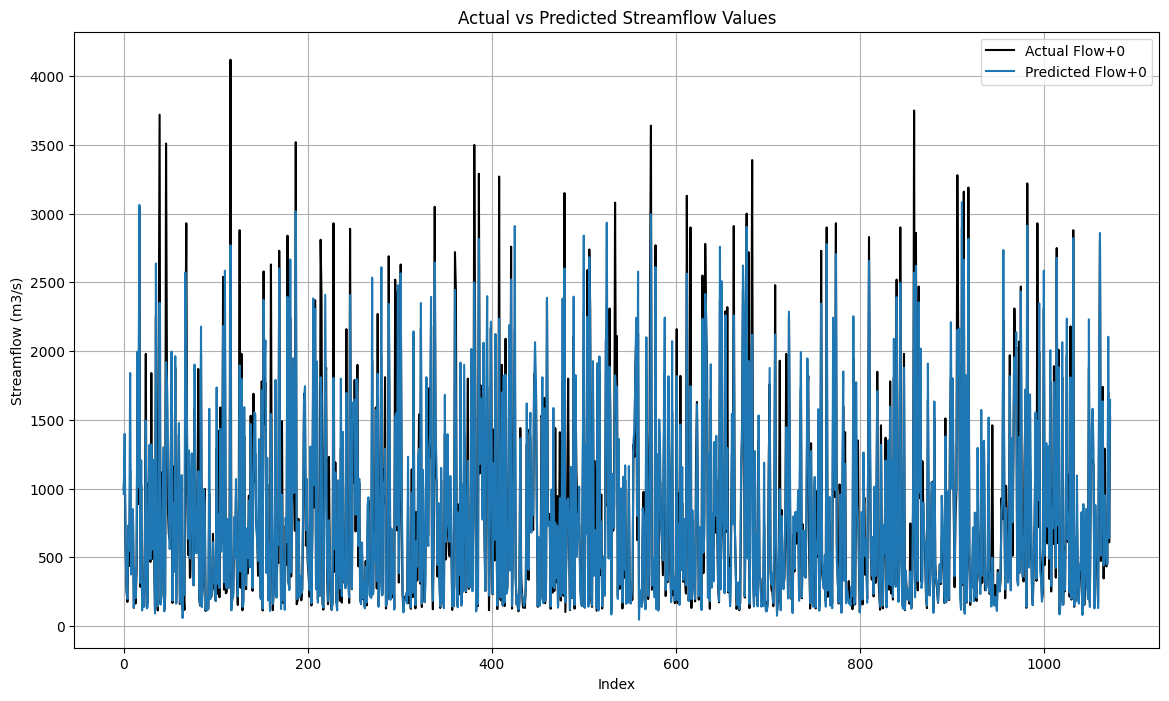

In [ ]:
plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted for each Flow
for i in range(y_pred.shape[1]):
    plt.plot(range(len(y_test)), y_test[:, i], label=f'Actual Flow+{i}', color='black')
    plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted Flow+{i}', color=f'C{i}')

# plt.plot(range(len(y_test)), y_test, label=f'Actual Flow+0', color='black')
# plt.plot(range(len(y_pred)), y_pred, label=f'Predicted Flow+0', color=f'C0')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
# # Fit the model with validation split to get training and validation loss
# history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

# # Plot training & validation loss values
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


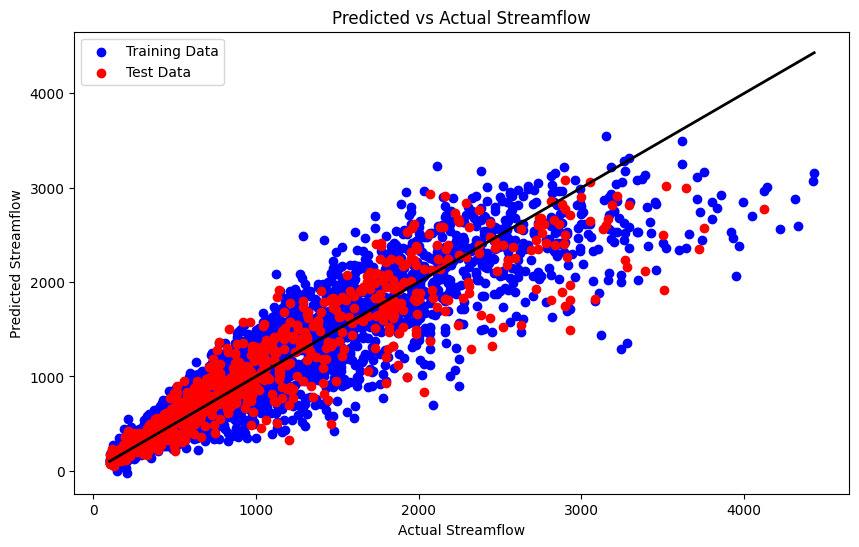

In [ ]:
# Make predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# Reverse the scaling to compare actual values
y_train_actual = scaler_Y.inverse_transform(y_train)
y_pred_train_actual = scaler_Y.inverse_transform(y_pred_train)

y_test_actual = y_test
y_pred_test_actual = scaler_Y.inverse_transform(y_pred_test)

# Plot predicted vs actual streamflow for training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train_actual, y_pred_train_actual, color='blue', label='Training Data')
plt.scatter(y_test_actual, y_pred_test_actual, color='red', label='Test Data')
plt.plot([min(y_train_actual), max(y_train_actual)], [min(y_train_actual), max(y_train_actual)], color='black', linewidth=2)
plt.title('Predicted vs Actual Streamflow')
plt.xlabel('Actual Streamflow')
plt.ylabel('Predicted Streamflow')
plt.legend(loc='upper left')
plt.show()


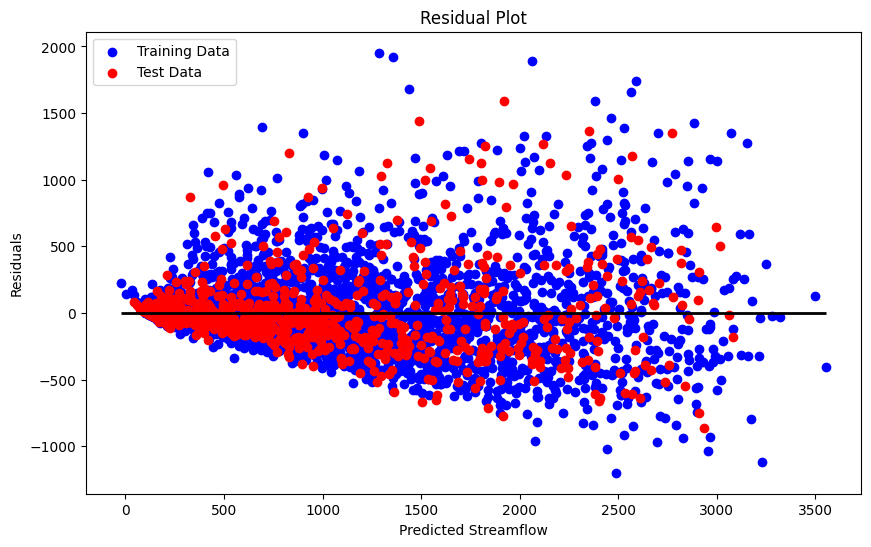

In [ ]:
# Calculate residuals
residuals_train = y_train_actual.flatten() - y_pred_train_actual.flatten()
residuals_test = y_test_actual.flatten() - y_pred_test_actual.flatten()

# Plot residuals for training and test data
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train_actual.flatten(), residuals_train, color='blue', label='Training Data')
plt.scatter(y_pred_test_actual.flatten(), residuals_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=min(y_pred_train_actual), xmax=max(y_pred_train_actual), color='black', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Streamflow')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# from sklearn.inspection import permutation_importance

# # Calculate permutation importance
# perm_importance = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42)

# # Plot feature importances
# feature_names = X.columns
# sorted_idx = perm_importance.importances_mean.argsort()

# plt.figure(figsize=(10, 6))
# plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel('Permutation Importance')
# plt.title('Feature Importance')
# plt.show()


In [ ]:
new_data = pd.read_csv('Data/BC/liard1944-2013.csv')
# new_data = pd.read_csv('Data/BC/collective1972-2023.csv')
# new_data = new_data[~new_data['CITY'].isin(['Jasper', 'Prince George'])]

# Extract year, month, and day into separate columns
new_data['LOCAL_DATE'] = pd.to_datetime(new_data['LOCAL_DATE'])
new_data = pd.get_dummies(new_data, columns=['SYM'], dummy_na=True)
# new_data['Month'] = new_data['LOCAL_DATE'].dt.month
# new_data = pd.get_dummies(new_data, columns=['Month'])


# Drop any non-numeric columns that aren't needed for training
new_data.drop(['LOCAL_DATE', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST',  
          'COOLING_DEGREE_DAYS', 'TOTAL_RAIN','TOTAL_SNOW', 'SNOW_ON_GROUND', 'Flow-2', 'Flow-3', 'HEATING_DEGREE_DAYS'], axis=1, inplace=True)

# # Create new columns with flow values after 1 day, 2 days, 3 days
new_data['Flow+1'] = new_data['Flow0'].shift(-1)  # Shift up by 1
new_data['Flow+2'] = new_data['Flow0'].shift(-2)  # Shift up by 2
new_data['Flow+3'] = new_data['Flow0'].shift(-3)  # Shift up by 3


# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# new_data_imputed = pd.DataFrame(imputer.fit_transform(new_data), columns=new_data.columns)
# Linear interpolation (default)
new_data_imputed = new_data.interpolate(method='linear')
new_data_imputed = new_data.dropna()

print(new_data_imputed.describe())
# Define X and Y
Y2 = new_data_imputed[['Flow+3']]  # Target variable
# Y2 = new_data_imputed[['Flow+3']]  # Target variable
X2 = new_data_imputed.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X2 = new_data_imputed.drop(['Flow0'], axis=1)  # Features

scaler_X2 = StandardScaler()
scaler_Y2 = StandardScaler()

X_scaled2 = scaler_X2.fit_transform(X2)
# Y_scaled = scaler_Y2.fit_transform(Y2.values.reshape(-1, 1)).flatten()
Y_scaled2 = scaler_Y2.fit_transform(Y2)


y_pred_scaled2 = model.predict(X_scaled2)

# Inverse transform predictions
y_pred2 = scaler_Y.inverse_transform(y_pred_scaled2)
y_pred2 = np.maximum(y_pred2, 0)  # Ensure no negative predictions


       MAX_REL_HUMIDITY  MIN_REL_HUMIDITY  TOTAL_PRECIPITATION  \
count      10076.000000      10076.000000         10076.000000   
mean          87.429933         52.825923             1.211086   
std            8.408866         18.794484             2.884636   
min           37.000000          6.000000             0.000000   
25%           83.000000         37.000000             0.000000   
50%           89.000000         52.000000             0.000000   
75%           93.000000         70.000000             1.000000   
max          100.000000         97.000000            41.800000   

       MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEMPERATURE         Flow0  \
count     10076.000000      10076.000000     10076.000000  10076.000000   
mean          4.937426         -0.864063        -6.671894   1249.652243   
std          14.243872         13.897931        13.942096   1309.578211   
min         -38.100000        -43.300000       -50.300000    125.000000   
25%          -6.100000        

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize lists to store the metrics
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
mape_list = []
accuracy_list = []

# Small value to avoid division by zero
epsilon = 1e-10

# Loop through each target variable (Flow0, Flow+1, etc.)
for i in range(y_pred.shape[1]):
    # Calculate errors
    errors = abs(y_pred[:, i] - y_test[:, i])

    # Mean Absolute Error (MAE)
    mae = np.mean(errors)
    mae_list.append(mae)
    print(f"Mean Absolute Error (Flow +{i}): {round(mae, 2)} m3/s")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mse_list.append(mse)
    print(f"Mean Squared Error (Flow +{i}): {round(mse, 2)}")

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(rmse, 2)}")

    # R-squared (R²)
    r_squared = r2_score(y_test[:, i], y_pred[:, i])
    r2_list.append(r_squared)
    print(f"R-squared (Flow +{i}): {round(r_squared, 2)}")

    # Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / (y_test[:, i] + epsilon))  # Add epsilon to avoid division by zero
    mean_mape = np.mean(mape)
    mape_list.append(mean_mape)
    print(f"MAPE (Flow +{i}): {round(mean_mape, 2)}%")
    
    # Calculate accuracy (100% - MAPE)
    accuracy = 100 - mean_mape
    accuracy_list.append(accuracy)
    print(f"Accuracy (Flow +{i}): {round(accuracy, 2)}%\n")


Mean Absolute Error (Flow +0): 155.27 m3/s
Mean Squared Error (Flow +0): 70159.02
Root Mean Squared Error (Flow +0): 264.88
R-squared (Flow +0): 0.88
MAPE (Flow +0): 17.92%
Accuracy (Flow +0): 82.08%



In [ ]:
# Define the range of indices you want to plot
start_index = 2000
end_index = 2400


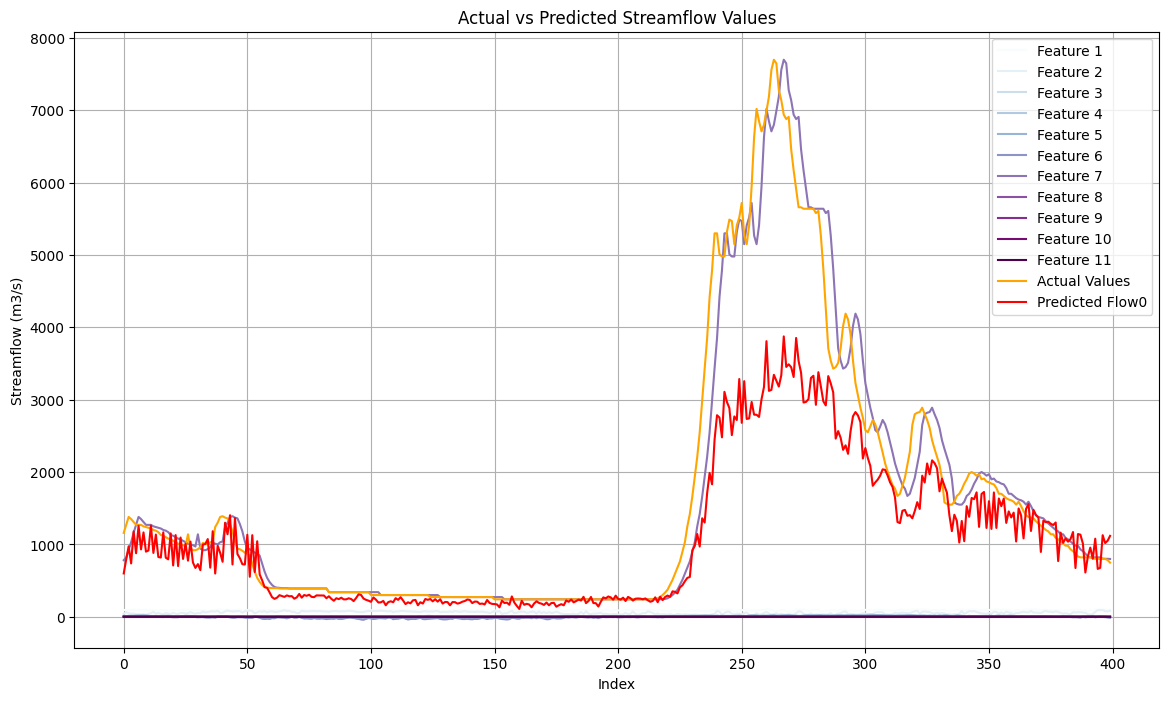

In [ ]:

# Ensure indices are within bounds
start_index = max(start_index, 0)
end_indexY = min(end_index, len(Y2))
end_indexX = min(end_index, len(X2))

# Slice the arrays
Y2_subset = Y2.iloc[start_index:end_indexY]
y_pred2_subset = y_pred2[start_index:end_indexY]
X2_subset = X2[start_index:end_indexX]

plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted for each Flow
#Define a color map for features
colors = plt.cm.BuPu(np.linspace(0, 1, X2.shape[1]))

# Plot each feature with a different color
for i in range(X2.shape[1]):
    plt.plot(range(len(X2_subset)), X2_subset.iloc[:, i], color=colors[i], label=f'Feature {i+1}')
plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 0], color='orange', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 1], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 3], color='blue', label='Actual Values')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 0], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 1], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 2], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 3], color='green', label='Feature')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset, color='red', label='Predicted Flow0')
plt.plot(range(len(y_pred2_subset)), y_pred2_subset[:, 0], color='red', label='Predicted Flow0')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 1], color='red', label='Predicted Flow+1')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 3], color='red', label='Predicted Flow+3')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
